In [1]:
# read all npz files in a directory and plot the data
import os
import numpy as np
import pandas as pd

!pip install matplotlib -Uqqqq
import matplotlib.pyplot as plt

In [2]:
def process_cf(data_path):
    # get all npz files in the directory
    npz_files = [f for f in os.listdir(data_path) if f.endswith(".npz")]

    # reorder the files by the number in the file name
    get_id = lambda x: int(x.split("_")[1].split(".")[0])
    npz_files = sorted(npz_files, key=get_id)

    # read one of the npz files
    cf_perturbed = []
    for npz_file in npz_files:
        data = np.load(os.path.join(data_path, npz_file), allow_pickle=True)
        cf_perturbed.append(
            [get_id(npz_file)] + list(data["delta_in_percentage"].item().values())
        )
    data = pd.DataFrame(
        cf_perturbed,
        columns=[
            "patch_id",
        ]
        + [name for name in data["delta_in_percentage"].item().keys()],
    )

    # zero out minor changes
    data[np.abs(data) < 1] = 0

    return data

In [3]:
data = {}
list_of_data = ["ray"]
for run in list_of_data:
    data_path = (
        f"/groups/mthomson/zwang2/IMC/output/cedarsLiver_sz48_pxl3_nc44/temp/cf/{run}/"
    )
    data[run] = process_cf(data_path)
    print(len(data[run]))

153


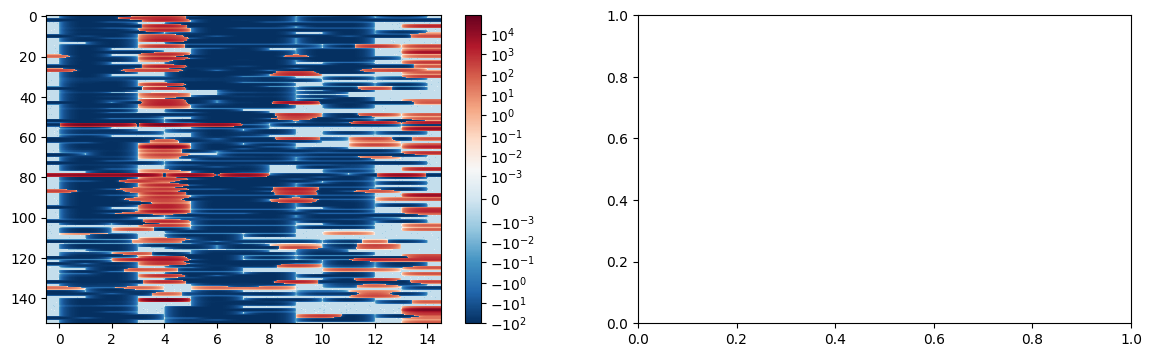

In [4]:
# plot in signed-log scale using imshow
from matplotlib.colors import SymLogNorm

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
# colormap in signed-log scale
for ii, name in enumerate(list_of_data):
    im = ax[ii].imshow(
        data[name].iloc[:, 1:],
        cmap="RdBu_r",
        aspect="auto",
        norm=SymLogNorm(linthresh=1e-3),
        interpolation=None,
    )
    fig.colorbar(im, ax=ax[ii])
plt.show()

Glnsynthetase      0.000000
CCR4            -100.000000
PDL1             -94.861069
LAG3               0.000000
CD105endoglin      0.000000
TIM3               0.000000
CXCR4           -100.000000
PD1              -90.330002
CYR61           -100.000000
CD44               0.000000
IL10               0.000000
CXCL12           -31.983719
CXCR3              0.000000
Galectin9          0.000000
YAP                0.000000
dtype: float32


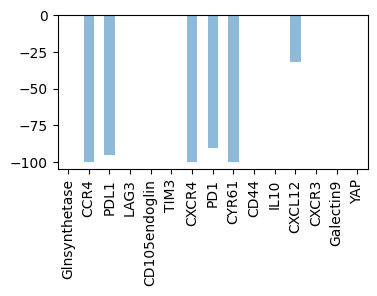

In [5]:
# make bar plot from median of the data (except for first column)
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
for name in list_of_data:
    data[name].iloc[:, 1:].median().plot(kind="bar", ax=ax, alpha=0.5)
    print(data[name].iloc[:, 1:].median())
plt.show()

In [6]:
import morpheus as mp

data_path = "/groups/mthomson/zwang2/IMC/output/cedarsLiver_sz48_pxl3_nc44/temp/singlecell.csv"  # change to your own directory
dataset = mp.SpatialDataset(input_path=data_path)

/central/home/zwang2/.cache/pypoetry/virtualenvs/morpheus-spatial-ndDQRg-x-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-18 20:56:28,792	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Channel names inferred from input CSV: ['CD45', 'Glnsynthetase', 'CD163', 'NKG2D', 'CCR4', 'PDL1', 'FAP', 'CD11c', 'LAG3', 'HepPar1', 'FOXP3', 'aSMA', 'CD4', 'CD105endoglin', 'CD68', 'VISTA', 'CD20', 'CD8a', 'TIM3', 'CXCR4', 'PD1', 'iNOS', 'CD31', 'CYR61', 'CDX2', 'CAIX', 'CD3', 'CD44', 'CD15', 'CD11b', 'HLADR', 'IL10', 'CXCL12', 'HLAABC', 'DNA1', 'DNA2', 'GranzymeB', 'Ki67', 'HistoneH3', 'CXCR3', 'Galectin9', 'YAP', 'CD14', 'CK19']


In [7]:
# combine dataset.metadata with data_tf using the patch_id
data["ray"]["patch_id"] = data["ray"]["patch_id"].astype(int)
data["ray"] = data["ray"].merge(
    dataset.metadata[["patch_id", "PatientID", "ImageNumber"]], on="patch_id"
)

<Axes: >

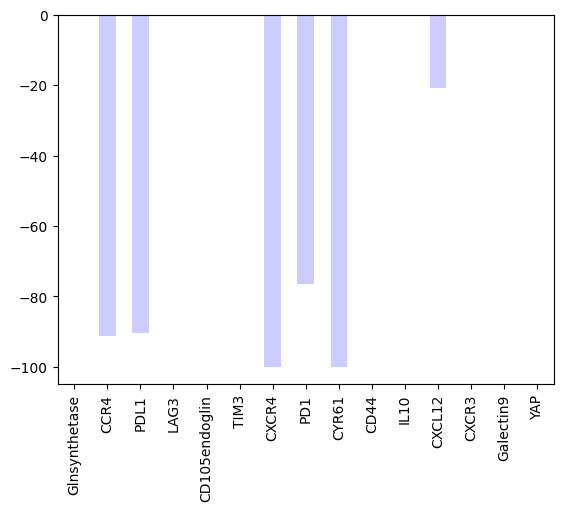

In [8]:
data["ray"].iloc[:, 1:-1].groupby("PatientID").median().median().plot(
    kind="bar", color="b", alpha=0.2
)